# Validate created parquet files

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/08 00:21:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/08 00:21:43 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-snakeclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Thu Feb  8 00:21:50 UTC 2024
gs://dsgt-clef-snakeclef-2024/data/parquet_files/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-large_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-medium_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/SnakeCLEF2023-train-small_size/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/


### load the datasets

In [4]:
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    BinaryType,
    IntegerType,
    BooleanType,
)

# Define the schema based on the provided structure
schema = StructType(
    [
        StructField("image_path", StringType(), True),
        StructField("path", StringType(), True),
        StructField("folder_name", StringType(), False),
        StructField("year", StringType(), True),
        StructField("binomial_name", StringType(), True),
        StructField("file_name", StringType(), True),
        StructField("data", BinaryType(), True),
        StructField("observation_id", IntegerType(), True),
        StructField("endemic", BooleanType(), True),
        StructField("code", StringType(), True),
        StructField("class_id", IntegerType(), True),
        StructField("subset", StringType(), True),
    ]
)

# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/"
small_size = "SnakeCLEF2023-train-small_size"
medium_size = "SnakeCLEF2023-train-medium_size"
large_size = "SnakeCLEF2023-train-large_size"

# Define the GCS path to the Train parquet file
small_gcs_path = f"{gcs_path}{small_size}"
medium_gcs_path = f"{gcs_path}{medium_size}"
large_gcs_path = f"{gcs_path}{large_size}"


# Read the Parquet file into a DataFrame
small_df = spark.read.schema(schema).parquet(small_gcs_path)
medium_df = spark.read.schema(schema).parquet(medium_gcs_path)
large_df = spark.read.schema(schema).parquet(large_gcs_path)

# Show the data (for example, first few rows)
small_df.show(n=3)

+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|          image_path|                path|         folder_name|year|       binomial_name|    file_name|                data|observation_id|endemic|code|class_id|subset|
+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_po...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1993| Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 1...|      64030606|  false|  EC|    1287| train|
|1995/Acrantophis_...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1995|Acrantophis_dumerili| 99694826.jpg|[FF D8 FF E0 00 1...|      62240606|   true|  MG|      11| train|
|1996/Ficimia_stre...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1996|   Ficimia_streckeri| 29265846.jpg|[FF D8 FF E0 00 1...|       2442697|  false|  

In [5]:
# Rows in small not in medium
diff_sml_med = small_df.exceptAll(medium_df)

# Rows in medium not in small
diff_med_sml = medium_df.exceptAll(small_df)

# show
small_df.show(n=3, truncate=100)
medium_df.show(n=3, truncate=100)

+--------------------------------------+----------------------------------------------------------------+------------------------+----+--------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|                            image_path|                                                            path|             folder_name|year|       binomial_name|    file_name|                                                                                                data|observation_id|endemic|code|class_id|subset|
+--------------------------------------+----------------------------------------------------------------+------------------------+----+--------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_polylepis/102870166.jpg|/SnakeCLEF20

+--------------------------------------+-----------------------------------------------------------------+-------------------------+----+---------------------+------------+----------------------------------------------------------------------------------------------------+--------------+-------+-------+--------+------+
|                            image_path|                                                             path|              folder_name|year|        binomial_name|   file_name|                                                                                                data|observation_id|endemic|   code|class_id|subset|
+--------------------------------------+-----------------------------------------------------------------+-------------------------+----+---------------------+------------+----------------------------------------------------------------------------------------------------+--------------+-------+-------+--------+------+
|1991/Elaphe_quatuorlineata/3000817.j

In [6]:
# Perform an anti-join to find rows in med_df that do not exist in sml_df based on image_path
differences = medium_df.join(small_df, "image_path", "left_anti")

# Show the results
differences.show(n=5, truncate=100)

+------------------------------------------+---------------------------------------------------------------------+-------------------------+----+------------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|                                image_path|                                                                 path|              folder_name|year|           binomial_name|    file_name|                                                                                                data|observation_id|endemic|code|class_id|subset|
+------------------------------------------+---------------------------------------------------------------------+-------------------------+----+------------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|2019/Hyps

In [7]:
differences.count()

276

In [8]:
from pyspark.sql.functions import col

small_df.where(col("image_path") == "2019/Hypsiglena_ochrorhynchus/68486239.jpg").show()

+----------+----+-----------+----+-------------+---------+----+--------------+-------+----+--------+------+
|image_path|path|folder_name|year|binomial_name|file_name|data|observation_id|endemic|code|class_id|subset|
+----------+----+-----------+----+-------------+---------+----+--------------+-------+----+--------+------+
+----------+----+-----------+----+-------------+---------+----+--------------+-------+----+--------+------+



In [9]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

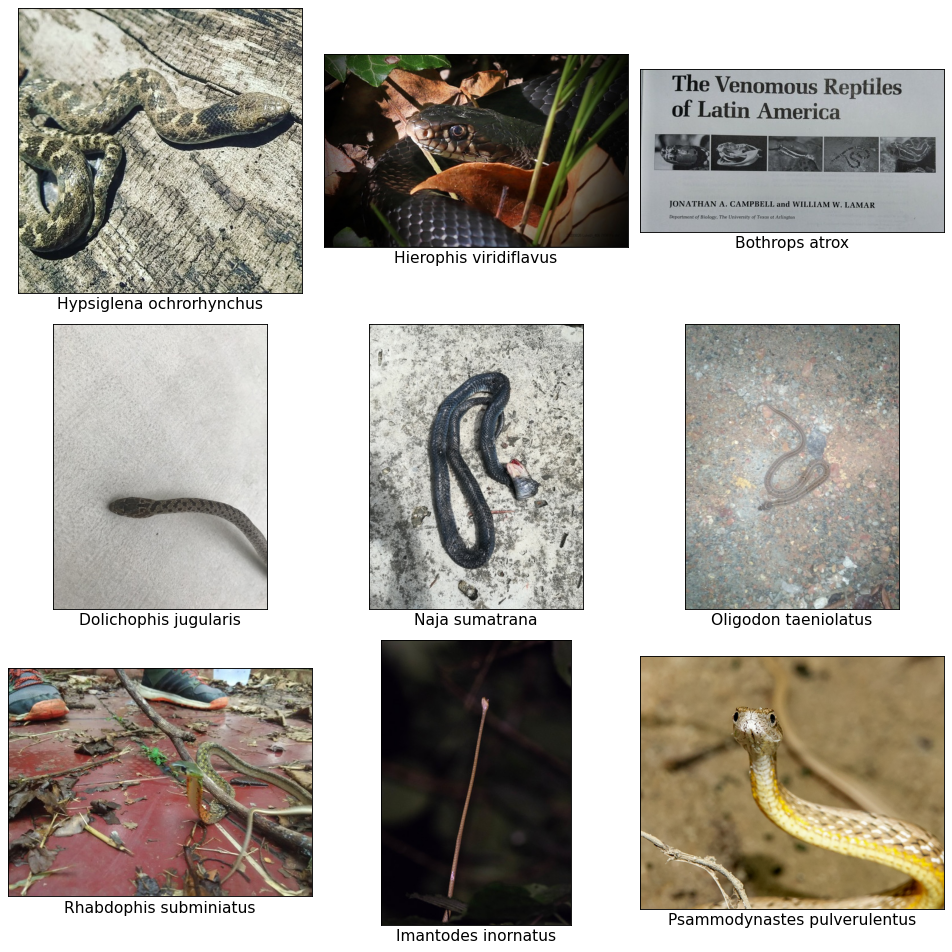

In [10]:
# Collect binary image data from DataFrame
df = differences
rows, cols = 3, 3
image_data_list = [row["data"] for row in df.limit(rows * cols).collect()]
binomial_names = [row["binomial_name"] for row in df.limit(rows * cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))

In [11]:
df.limit(9).show(truncate=100)

+-----------------------------------------------+--------------------------------------------------------------------------+-------------------------+----+----------------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|                                     image_path|                                                                      path|              folder_name|year|               binomial_name|    file_name|                                                                                                data|observation_id|endemic|code|class_id|subset|
+-----------------------------------------------+--------------------------------------------------------------------------+-------------------------+----+----------------------------+-------------+----------------------------------------------------------------------------------------------------+-------------

### check train large size df

In [12]:
large_df.count()

68638

In [13]:
# Perform an anti-join to find rows in med_df that do not exist in sml_df based on image_path
large_diff = large_df.join(small_df, "image_path", "left_anti")

# Show the results
large_diff.show(n=5, truncate=100)

+-------------------------------------------+---------------------------------------------------------------------+------------------------+----+------------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
|                                 image_path|                                                                 path|             folder_name|year|           binomial_name|    file_name|                                                                                                data|observation_id|endemic|code|class_id|subset|
+-------------------------------------------+---------------------------------------------------------------------+------------------------+----+------------------------+-------------+----------------------------------------------------------------------------------------------------+--------------+-------+----+--------+------+
| 2016/Ste

In [14]:
large_diff.count()

143

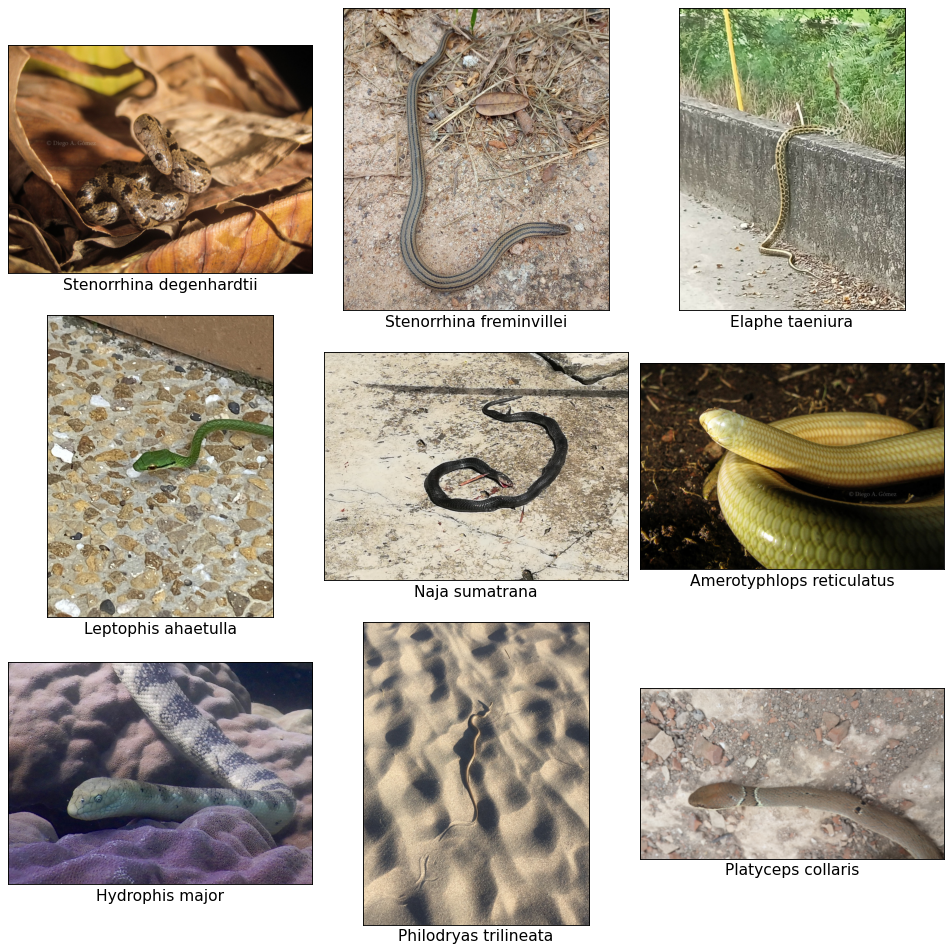

In [15]:
# Collect binary image data from DataFrame
df = large_diff
rows, cols = 3, 3
image_data_list = [row["data"] for row in df.limit(rows * cols).collect()]
binomial_names = [row["binomial_name"] for row in df.limit(rows * cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))